#  1 Agent-on-pores 2D model on a rectangle


In 2D, the nondimensional coupled PDEs for $c(x,y,t)$ and $R(x,y,t)$ become (equation $(3.36)$ of the final version of the paper):

\begin{equation}
c_t = \dfrac{1}{\mathcal{V}(R)} \nabla \cdot \left( \mathcal{V}(R) \mathbf{D} \nabla c \right) - \mathcal{H}(R) \mathcal{F}(R) (1+ \gamma c) \beta c, \\
R_t = - \mathcal{H}(R) \beta \gamma c,
\end{equation}

where $\mathcal{H}(R)$ is the Heaviside function, which is $0$ for $R<0$, equals $1$ for $R>0$, and we set it to be $0$ for $R = 0$. 

Here, we also use the following notation: 
- $\mathbf{D} = \mathbf{D}(R+r)$: the effective diffusivity (depending on the pore and the agent coating), proportional to the identity matrix due to the symmetry of the circular geometry. 
- $\mathcal{V}(R)$: the 2D area occupied by the cleanser in the unit cell, $1 - \pi(r+R_0)^2$.
- $\mathcal{L}(R)$: the length of the agent-cleanser interface, $2 \pi (r+R_0)$.
- $\mathcal{F}(R)$: the ratio $\mathcal{L}(R)/ \mathcal{V}(R)$.

We solve the problem on a more general rectangular domain $\Omega = [0,a] \times [0,b]$. The accompanying boundary conditions for the cleanser concentration remain the same as before: 

\begin{equation}
c(x,0,t) = 1, \\
\dfrac{\partial c}{\partial y}(x,b,t) = 0, \\
\dfrac{\partial c}{\partial x}(0,y,t) = 0, \\
\dfrac{\partial c}{\partial x}(a,y,t) = 0.
\end{equation}

Note the second condition can either be a normal derivative or $c(x,b,t) = 0$, depending on whether we consider a Neumann or a Dirichlet scenario. There is also an initial condition for the first-order PDE for $R$ and for $c$:

\begin{equation}
R(x,y,0) = R_0. \\
c(x,y,0) = 0. 
\end{equation}

We obtain the variational formulation by multiplying with a suitable test function and summing up the two equations. But first, we need to introduce a discretisation in time. With the notation and approach as in the previous section, the PDEs become (at time $t_{n+1}$):

\begin{equation}
\mathcal{V}(R^{n+1}) (c^{n+1} - c^{n}) = \Delta t \nabla \cdot \left( \mathcal{V}(R^{n+1}) \mathbf{D} \nabla c^{n+1} \right)- \Delta t \mathcal{H}(R^{n+1}) \mathcal{L}(R^{n+1}) (1+ \gamma c^{n+1}) \beta c^{n+1}, \\
R^{n+1} - R^{n} = - \Delta t \mathcal{H}(R^{n+1}) \beta \gamma c^{n+1}.
\end{equation}

Next, we multiply by a test function $v$ (which vanishes on the boundary $y=0$), so that by integration by parts:

\begin{equation}
\int_{\Omega} v \nabla \cdot \left( \mathcal{V}(R) \mathbf{D} \nabla c \right) dx dy = \int_{\partial \Omega} v \mathbf{D} \mathcal{V}(R) \nabla c \cdot \mathbf{n} ds - \int_{\Omega} \nabla v \cdot \mathbf{D} \mathcal{V}(R)  \nabla c dx dy = - \int_{\Omega} \nabla v \cdot \mathbf{D} \mathcal{V}(R)  \nabla c dx dy.
\end{equation}

The line integral vanishes for the same reason as in the previous scenario (coating of agent layer thin compared to the pore lengthscale), and we work with the same spaces for our solution and the test function as previously. 

Unlike the previous case, we need to be careful with the space of test functions we work with, and introduce two different test functions in the problem (as this is a system of two coupled PDEs). We let $v_1$ be the test function corresponding to the PDE with the $c$ time derivative, and let $v_2$ be the test function corresponding to the PDE with the $R$ time derivative.

Next, dropping $n+1$ superscripts, our variational problem becomes:

\begin{equation}
F_{n+1}(c, R; v_1,  v_2) = \int_{\Omega} \dfrac{v_1 \mathcal{V}(R)(c-c^n)}{\Delta t} + \nabla v_1  \cdot \left( \mathbf{D} \mathcal{V}(R) \nabla c \right) + v_1 \mathcal{H}(R) \mathcal{L}(R) (1 + \gamma c)\beta c + \dfrac{v_2 (R-R^{n})}{\Delta t} + v_2 \mathcal{H}(R) \beta \gamma c dx dy = 0.
\end{equation}

In fact, if we implement an implicit midpoint method, we may set:

\begin{equation}
\tilde{c} = \dfrac{1}{2} \left( c^{n+1} + c^{n} \right),
\end{equation}

\begin{equation}
\tilde{R} = \dfrac{1}{2} \left( R^{n+1} + R^{n} \right),
\end{equation}

and replace all $c^{n+1}$ terms that do not come from the time derivatives as previously, to obtain:

\begin{equation}
F_{n+1}(c, R;v_1, v_2) = \int_{\Omega} \dfrac{v_1 \mathcal{V}(R)(c-c^n)}{\Delta t} + \nabla v_1  \cdot \left( \mathbf{D} \mathcal{V}(R) \nabla \tilde{c} \right) + v_1 \mathcal{H}(R) \mathcal{L}(R) (1 + \gamma \tilde{c})\beta \tilde{c} + \dfrac{v_2(R-R^{n})}{\Delta t} + v_2 \mathcal{H}(R) \beta \gamma \tilde{c} dx dy = 0.
\end{equation}

<b>This is one of the strengths of FEniCS: one can easily define variational problems that couple several PDEs into one compound system.</b> The result is a fully implicit (monolithic) solver. 

## 1.1 Interpolating the effective diffusivity

Here we use polynomial interpolation to create a new function, which will output the effective diffusivity within the porous medium for a given size of pore and coating layer (which together clog the medium diffused by the cleanser).

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
    
# We define a function which outputs the diffusivity for a given radius 
def effectivediffusivity(r):
    
    R1 = np.linspace(0,0.47,48) # Radii 0, 0.1, 0.2, ... , 0.47
    R2 = np.linspace(0.471,0.5,30) # Smaller steps for radii: 0.471, 0.472, ... , 0.5
    R = np.concatenate((R1, R2)) # All 78 arguments for calculations placed into one array. 

    # Effective diffusivities  for the particular radii from correspondence with  Mo Dalwadi. 

    D = np.array([1.0000, 0.9997, 0.9988, 0.9972, 0.9950, 0.9922, 0.9888, 0.9849, 0.9803, 0.9752,
                0.9696, 0.9634, 0.9567, 0.9496, 0.9420, 0.9340, 0.9256, 0.9168, 0.9076, 0.8982,
                0.8884, 0.8783, 0.8680, 0.8574, 0.8467, 0.8357, 0.8246, 0.8133, 0.8019, 0.7904,
                0.7787, 0.7668, 0.7548, 0.7427, 0.7303, 0.7177, 0.7048, 0.6915, 0.6776, 0.6631,
                0.6476, 0.6310, 0.6127, 0.5921, 0.5684, 0.5401, 0.5051, 0.4596, 0.4543, 0.4487,
                0.4430, 0.4370, 0.4309, 0.4244, 0.4178, 0.4109, 0.4036, 0.3961, 0.3883, 0.3800,
                0.3714, 0.3624, 0.3528, 0.3428, 0.3322, 0.3209, 0.3089, 0.2962, 0.2824, 0.2677,
                0.2516, 0.2340, 0.2145, 0.1925, 0.1671, 0.1365, 0.0962, 0.0000])
    
    
    # We use cubic interpolation in order to smooth out the resulting curve
    # This shouldn't be too dramatic as the function is monotonic anyways
    f_cubic = interp1d(R, D, 'cubic') 
    plt.plot(R, D, 'o', R, f_cubic(R), '--',)
    plt.xlabel("Radius of circle inscribed in unit square cell")
    plt.ylabel("Effective diffusivity in porous medium")
    plt.legend(['Data', 'Cubic interpolation'], loc = 'best')
    plt.show()
    
    return float(f_cubic(r))

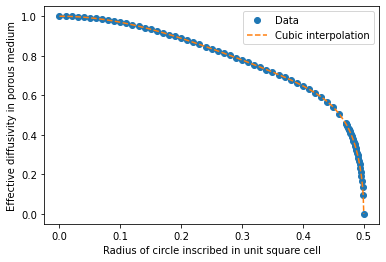

0.7787000000000001

In [2]:
effectivediffusivity(0.3)

## 1.2 Main function code

We integrate the timesteps and the spatial resolution within the function. For every 1x1 unit square, there is a 30x30 resolution of Lagrange finite elements. For every integer non-dimensional time, there are 25 

In [3]:
from __future__ import print_function
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
import sympy as sym 
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
from scipy.interpolate import interp1d
 
def agentonpores(T, r, a, b, R_0, c_star, beta, gamma, bc_bottom):    
    num_steps = int(np.ceil(T*25)) # num_steps are the number of timesteps in the discretisation of the grid
    dt = T / num_steps # time step size (predetermined by the number of timesteps)
    degree = 1 # the degree that determines the kind of elements we are using for the function space
    
    def vol(R,r): # Area of cleanser occupied region. 
        return 1 - np.pi *(r+R)**2

    def leng(R,r): # Local length of agent-cleanser interface.
        return 2*np.pi*(r+R)
    
    R1 = np.linspace(0,0.47,48) # Radii 0, 0.1, 0.2, ... , 0.47
    R2 = np.linspace(0.471,0.5,30) # Smaller steps for radii: 0.471, 0.472, ... , 0.5
    R_tot = np.concatenate((R1, R2)) # All 78 arguments for calculations placed into one array. 

    # Effective diffusivities for the particular radii of pores. 

    D = np.array([1.0000, 0.9997, 0.9988, 0.9972, 0.9950, 0.9922, 0.9888, 0.9849, 0.9803, 0.9752,
                0.9696, 0.9634, 0.9567, 0.9496, 0.9420, 0.9340, 0.9256, 0.9168, 0.9076, 0.8982,
                0.8884, 0.8783, 0.8680, 0.8574, 0.8467, 0.8357, 0.8246, 0.8133, 0.8019, 0.7904,
                0.7787, 0.7668, 0.7548, 0.7427, 0.7303, 0.7177, 0.7048, 0.6915, 0.6776, 0.6631,
                0.6476, 0.6310, 0.6127, 0.5921, 0.5684, 0.5401, 0.5051, 0.4596, 0.4543, 0.4487,
                0.4430, 0.4370, 0.4309, 0.4244, 0.4178, 0.4109, 0.4036, 0.3961, 0.3883, 0.3800,
                0.3714, 0.3624, 0.3528, 0.3428, 0.3322, 0.3209, 0.3089, 0.2962, 0.2824, 0.2677,
                0.2516, 0.2340, 0.2145, 0.1925, 0.1671, 0.1365, 0.0962, 0.0000])

    # We use cubic interpolation in order to smooth out the resulting curve

    diffvals = interp1d(R_tot, D, 'cubic') 
    
    # Approximation to the Heaviside function using interpolation

    Rad = np.array([-1,0,1e-14,1]) # The domain where we evaluate the Heaviside function
    Heavisideapprox = np.array([0, 0, 1, 1]) 
    heavivals = interp1d(Rad, Heavisideapprox, 'linear') 


    # Create mesh and define function space
    nx = int(np.ceil(30*a)) # Specifying the horizontal resolution of our mesh
    ny = int(np.ceil(30*b)) # Specifying the vertical resolution of our mesh
    mesh = RectangleMesh(Point(0.0, 0.0), Point(a, b), nx, ny, "crossed")
    # Uniform, finite element mesh over the unit square.
    # The mesh consists of cells, which in 2D are triangles with straight lines.
    # Crossed mesh helps us preserve symmetry about the x- and y-axis. 

    # Defining a MixedElement as the product space of two simple finite elements.
    # Afterwards, using the mixed element to define the function space.

    # V = VectorFunctionSpace(mesh, 'P', 2, degree)
    P1 = FiniteElement('P', triangle, degree)
    element = MixedElement([P1, P1])
    V = FunctionSpace(mesh, element)
    # 'P' means that we are using the standard Lagrange family of elements.
    # The third argument specifies the degree of the finite element.
    # Patrick says that this is a sensible choice and should do the job, so I will stick with it. 
    
    VR = V.sub(1).collapse() # We extract the subspace of the second component (R)
    diffu = Function(VR) # The effective diffusivity is a function of R, so lives in this space
    heavi = Function(VR) # The "Heaviside" function is a function of R, so lives in this space
    zerofun = Function(VR) # A function of zeros to 

    # Define boundary condition - there is no cleanser initially at t = 0!
    # The first condition corresponds to no cleanser, the second to the initial radius.
    
    u_0 = Expression(('0', str(R_0)), degree=1)
    
    tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

    class BoundaryX0(SubDomain): # defining the boundary at x = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryXa(SubDomain): # defining the boundary at x = a
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], a, tol)

    class BoundaryY0(SubDomain): # defining the boundary at y = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, tol)

    class BoundaryYb(SubDomain): # defining the boundary at y = b
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], b, tol)  
    
    # We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
    # If instead we wanted to work with vertices, the dimension would be -2. 
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
    # This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bxa = BoundaryXa()
    by0 = BoundaryY0()
    byb = BoundaryYb()
    bx0.mark(boundary_markers, 0) # Assigning a "0" marker to x = 0 
    bxa.mark(boundary_markers, 1) # Assigning a "1" marker to x = a
    by0.mark(boundary_markers, 2) # Assigning a "2" marker to y = 0 
    byb.mark(boundary_markers, 3) # Assigning a "3" marker to y = b 

    # In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
    # There are three possibilities: Dirichlet, Neumann and Robin.
    # These conditions refer to the cleanser concentration, not to the radius of agent.
    # For each kind of condition, to the right we specify the function that this condition is assigned.

    boundary_conditions_cleanser = {0: {'Neumann': Expression('0', degree=1)}, # insulated left end
                            1: {'Neumann': Expression('0', degree=1)}, # insulated right end
                            2: {'Dirichlet': Expression(str(c_star), degree=1)}, # applied cleanser concentration on surface
                            3: {bc_bottom : Expression('0', degree=1)}} # insulated maximum depth / no cleanser

    bcs = [] # We first start with an empty array of boundary conditions, which we then fill.

    # Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
    # into account explicitly, as opposed to Neumann conditions within the variational formulation itself. 

    # We apply the boundary conditions to V.sub(0) - the cleanser (indexing in Python starts from zero)
    # This next for loop skips over anything that is not Dirichlet
    for i in boundary_conditions_cleanser:
        if 'Dirichlet' in boundary_conditions_cleanser[i]:
            bc = DirichletBC(V.sub(0), boundary_conditions_cleanser[i]['Dirichlet'],
                            boundary_markers, i)
            bcs.append(bc)

    # Define initial value for the solution vector, using the initial condition we set above.
    u_n = interpolate(u_0, V)
    # c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

    u =  interpolate(u_0, V) # A good initial guess = initial value! Newton is local, so we start close.
    v_1, v_2 = TestFunctions(V) # Test functions for cleanser PDE and radius PDE, respectively. 
    c, R = split(u) # The components of the solution vector (cleanser first, then radius).
    c_n, R_n = split(u_n) # The components of the discretised iterations, as above. 
    
    diffu.vector()[:] = float(diffvals(r+R_0)) # start from the effective diffusion at t=0 as initial guess 
    heavi.vector()[:] = float(heavivals(R_0)) # start from heaviside evaluated at initial radius

    c_= 0.5*(c+c_n)     # The "c tilde" for the implicit midpoint method

    # Variational formulation
    F = (c-c_n)/dt*v_1*vol(R,r)*dx + dot(grad(c_), grad(v_1))*vol(R,r)*diffu*dx \
    + v_1*heavi*leng(R,r)*beta*c_*(1+gamma*c_)*dx + v_2*(R-R_n)/dt*dx \
    + v_2*heavi*beta*gamma*c_*dx
    # language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

    # Time-stepping
    t = 0
    for n in range(num_steps):
        
        if n %  10 == 0:
            print(f"Step {n+1}") # Get a sense of how quickly our solver is converging

        # Update current time
        t += dt # add the timestep to the current time to move forward

        # Compute solution
        solve(F == 0, u, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
        
        # Split components of solution to evaluate the functions of R
        c, R = u.split(True) # 
        
        # The time iteration can make R slightly negative (then stops changing because of heaviside)
        # We therefore take a pointwise maximum with a zero vector to make sure R >= 0 everywhere
        R.vector()[:] = np.maximum(R.vector(), zerofun.vector())
        diffu.vector().set_local(diffvals(r+R.vector()[:])) # Evaluate the effective diffusivity 
        heavi.vector().set_local(heavivals(R.vector()[:])) # Evaluate the heaviside of the radius
        
        # Update previous solution
        u_n.assign(u) # We assign the values of u to u_n which contains values from previous timestep
        # Do not try to set u_n = u, as that will make the two variables exactly the same
        
    # Plot solution at the end of the simulation
    plt.figure(0)
    simulationplot1 = plot(c, title = "Cleanser concentration at end of simulation", mode = 'color')
    plt.colorbar(simulationplot1)
    plt.xlabel("Horizontal distance $(x)$")
    plt.ylabel("Depth within porous medium $(y)$")
    plt.gca().invert_yaxis()

    plt.figure(1)
    simulationplot2 = plot(R, title = "Radius of agent coating at end of simulation", mode = 'color')
    plt.colorbar(simulationplot2)
    plt.xlabel("Horizontal distance $(x)$")
    plt.ylabel("Depth within porous medium $(y)$")
    plt.gca().invert_yaxis()


Step 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Step 11
Step 21
Step 31
Step 41


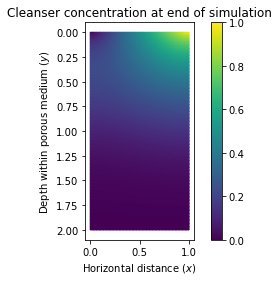

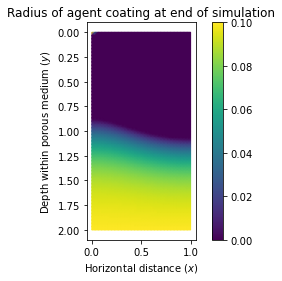

In [4]:
# TIME PARAMETERS: 

T = 2 # T is the time of simulation 

# PROBLEM GEOMETRY SPECIFICATION:

# We solve the problem on a rectangle: [0,a] x [0,b]
a = 1 # a is the maximum horizontal distance from the origin
b = 2 # b is the maximum depth of the porous medium 
r = 0.3 # r is the radius of the bit that's solid that clogs the medium

# PARAMETERS OF REACTION DUE TO CHEMISTRY:

beta = 2 # beta is the ratio of diffusion macroscale timescale / chemical reaction timescale  
gamma = 0.5 # gamma is the amount the interface moves due to these effects

# INITIAL CONDITION ON RADIUS

R_0 = 0.1 # R_0 is the initial radius of the coating layer, which is 0 < R < 1/2 - r

# BOUNDARY CONDITION ON CLEANSER CONCENTRATION

c_star = 'x[0]'

# BOUNDARY CONDITION AT BOTTOM OF MEDIUM 

bc_bottom = 'Dirichlet' # Choose between Dirichlet or Neumann conditions

agentonpores(T, r, a, b, R_0, c_star, beta, gamma, bc_bottom)

#  2 Agent-on-pores 1D model (general)

Here we adapt the code from above to work in a more specific, 1D setting. 

We preserve the variational formulation as below. The main difference now is that we are working on a 1D domain (instead of 2D) so that we solve the problem on an interval $[0, \text{max_depth})$ where max_depth is a large positive value (replacing infinity). We preserve the variational formualtion from above, but define new functional spaces and 1D meshes, so the Finite Element Method uses one-dimensional intervals as opposed to triangles. 



In [11]:
from __future__ import print_function
from dolfin import *
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
import sympy as sym 
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
from scipy.interpolate import interp1d
 
def agentonpores_1d(T, max_depth, r, R_0, beta, gamma, bc_maxdepth):   
    subintervals = int(np.ceil(max_depth*100))
    num_steps = int(np.ceil(T*25))
    dt = T / num_steps # time step size (predetermined by the number of timesteps)
    degree = 1 # the degree that determines the kind of elements we are using for the function space
    
    def vol(R,r): # Area of cleanser occupied region. 
        return 1 - np.pi *(r+R)**2

    def leng(R,r): # Local length of agent-cleanser interface.
        return 2*np.pi*(r+R)
    
    R1 = np.linspace(0,0.47,48) # Radii 0, 0.1, 0.2, ... , 0.47
    R2 = np.linspace(0.471,0.5,30) # Smaller steps for radii: 0.471, 0.472, ... , 0.5
    R_tot = np.concatenate((R1, R2)) # All 78 arguments for calculations placed into one array. 

    # Effective diffusivities for the particular radii of pores. 

    D = np.array([1.0000, 0.9997, 0.9988, 0.9972, 0.9950, 0.9922, 0.9888, 0.9849, 0.9803, 0.9752,
                0.9696, 0.9634, 0.9567, 0.9496, 0.9420, 0.9340, 0.9256, 0.9168, 0.9076, 0.8982,
                0.8884, 0.8783, 0.8680, 0.8574, 0.8467, 0.8357, 0.8246, 0.8133, 0.8019, 0.7904,
                0.7787, 0.7668, 0.7548, 0.7427, 0.7303, 0.7177, 0.7048, 0.6915, 0.6776, 0.6631,
                0.6476, 0.6310, 0.6127, 0.5921, 0.5684, 0.5401, 0.5051, 0.4596, 0.4543, 0.4487,
                0.4430, 0.4370, 0.4309, 0.4244, 0.4178, 0.4109, 0.4036, 0.3961, 0.3883, 0.3800,
                0.3714, 0.3624, 0.3528, 0.3428, 0.3322, 0.3209, 0.3089, 0.2962, 0.2824, 0.2677,
                0.2516, 0.2340, 0.2145, 0.1925, 0.1671, 0.1365, 0.0962, 0.0000])

    # We use cubic interpolation in order to smooth out the resulting curve

    diffvals = interp1d(R_tot, D, 'cubic') 
    
    # Approximation to the Heaviside function using interpolation

    Rad = np.array([-1,0,1e-14, 1]) # The domain where we evaluate the Heaviside function
    Heavisideapprox = np.array([0, 0, 1, 1]) 
    heavivals = interp1d(Rad, Heavisideapprox, 'linear') 


    # Create mesh and define function space
    mesh = IntervalMesh(subintervals, 0, max_depth) 
    # Splitting the interval [0, max_depth] into gridspacing many equal sub-intervals. 

    # V = VectorFunctionSpace(mesh, 'P', 2, degree)
    P1 = FiniteElement("Lagrange", interval, degree)
    element = MixedElement([P1, P1])
    V = FunctionSpace(mesh, element)
    # 'P' means that we are using the standard Lagrange family of elements.
    # The third argument specifies the degree of the finite element.
    # Patrick says that this is a sensible choice and should do the job, so I will stick with it. 
    
    VR = V.sub(1).collapse() # We extract the subspace of the second component (R)
    diffu = Function(VR) # The effective diffusivity is a function of R, so lives in this space
    heavi = Function(VR) # The "Heaviside" function is a function of R, so lives in this space
    zerofun = Function(VR) # A zero function living on the mesh, which we will use to make sure 
    # that radii never go below zero in the loop iteration 

    # Define initial condition - there is no cleanser initially at t = 0!
    # The first condition corresponds to no cleanser, the second to the initial radius.
    
    u_0 = Expression(('0', str(R_0)), degree=1)
    
    tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

    class BoundaryX0(SubDomain): # defining the boundary at y = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryXa(SubDomain): # defining the boundary at y = max_depth
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], max_depth, tol)
    
    # We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
    # If instead we wanted to work with vertices, the dimension would be -2. 
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
    # This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bxa = BoundaryXa()
    bx0.mark(boundary_markers, 0) # Assigning a "0" marker to y = 0 
    bxa.mark(boundary_markers, 1) # Assigning a "1" marker to y = max_depth


    # In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
    # There are three possibilities: Dirichlet, Neumann and Robin.
    # These conditions refer to the cleanser concentration, not to the radius of agent.
    # For each kind of condition, to the right we specify the function that this condition is assigned.

    boundary_conditions_cleanser = {0: {'Dirichlet': Expression('1', degree=1)}, # insulated left end
                            1: {bc_maxdepth: Expression('0', degree=1)}} # insulated maximum depth / no cleanser

    bcs = [] # We first start with an empty array of boundary conditions, which we then fill.

    # Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
    # into account explicitly, as opposed to Neumann conditions within the variational formulation itself. 

    # We apply the boundary conditions to V.sub(0) - the cleanser (indexing in Python starts from zero)
    # This next for loop skips over anything that is not Dirichlet
    for i in boundary_conditions_cleanser:
        if 'Dirichlet' in boundary_conditions_cleanser[i]:
            bc = DirichletBC(V.sub(0), boundary_conditions_cleanser[i]['Dirichlet'],
                            boundary_markers, i)
            bcs.append(bc)

    # Define initial value for the solution vector, using the initial condition we set above.
    u_n = interpolate(u_0, V)
    #c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

    u =  interpolate(u_0, V) # A good initial guess = initial value! Newton is local, so we start close.
    v_1, v_2 = TestFunctions(V) # Test functions for cleanser PDE and radius PDE, respectively. 
    c, R = split(u) # The components of the solution vector (cleanser first, then radius).
    c_n, R_n = split(u_n) # The components of the discretised iterations, as above. 
    
    diffu.vector()[:] = float(diffvals(r+R_0)) # start from the effective diffusion at t=0 as initial guess 
    heavi.vector()[:] = float(heavivals(R_0)) # start from heaviside evaluated at initial radius

    c_= 0.5*(c+c_n)     # The "c tilde" for the implicit midpoint method

    # Variational formulation
    F = (c-c_n)/dt*v_1*vol(R,r)*dx + dot(grad(c_), grad(v_1))*vol(R,r)*diffu*dx \
    + v_1*heavi*leng(R,r)*beta*c_*(1+gamma*c_)*dx + v_2*(R-R_n)/dt*dx \
    + v_2*heavi*beta*gamma*c_*dx
    # language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

    # Time-stepping
    t = 0

    for n in range(num_steps):
        
        if n % 20 == 0:
            print(f"Step {n+1}") # Get a sense of how quickly our solver is converging

        # Update current time
        t += dt # add the timestep to the current time to move forward

        # Compute solution
        solve(F == 0, u, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
        
        # Split components of solution to evaluate the functions of R
        c, R = u.split(True)
        
        # The time iteration can make R slightly negative (then stops changing because of heaviside)
        # We therefore take a pointwise maximum with a zero vector to make sure R >= 0 everywhere
        R.vector()[:] = np.maximum(R.vector(), zerofun.vector()) 
        diffu.vector().set_local(diffvals(r+R.vector()[:])) # Evaluate the effective diffusivity 
        heavi.vector().set_local(heavivals(R.vector()[:])) # Evaluate the heaviside of the radius
        
        # Update previous solution
        u_n.assign(u) # We assign the values of u to u_n which contains values from previous timestep
        # Do not try to set u_n = u, as that will make the two variables exactly the same

        if n % int(np.ceil(num_steps/5)) == 0 or n == num_steps - 1: 
            # Plot solution at the end of the simulation and intermediate time points
            plt.figure(0)
            plot(c, title = "Cleanser concentration snapshot", label = "$t=$" + str(round(t,3)))
            plt.xlabel("Depth within porous medium $(y)$")
            plt.ylabel("Cleanser concentration $c(y,t)$")
            plt.legend()

            plt.figure(1)
            plot(R, title = "Radius of agent coating snapshot", label = "$t=$" + str(round(t,3)))
            plt.xlabel("Depth within porous medium $(y)$")
            plt.ylabel("Radius of coating $R(y,t)$")
            plt.ylim(-0.01,R_0+0.01)
            plt.legend()


Step 1
Step 21
Step 41
Step 61
Step 81
Step 101
Step 121
Step 141
Step 161
Step 181
Step 201
Step 221
Step 241
Step 261
Step 281
Step 301
Step 321
Step 341
Step 361
Step 381
Step 401
Step 421
Step 441
Step 461
Step 481


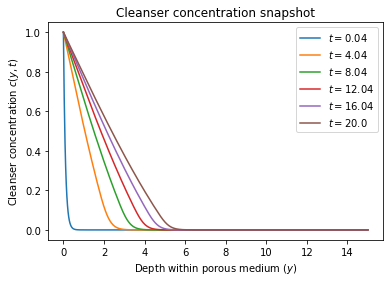

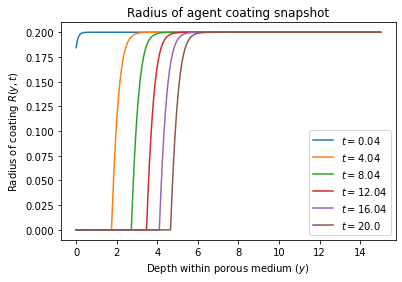

In [13]:
# TIME PARAMETERS: 

T = 20 # T is the time of simulation 

# PROBLEM GEOMETRY SPECIFICATION:

# We solve the problem on an interval [0, max_depth]
max_depth = 15
r = 0.25 # r is the radius of the bit that's solid that clogs the medium

# PARAMETERS OF REACTION DUE TO CHEMISTRY:

beta = 1.3 # beta is the ratio of diffusion macroscale timescale / chemical reaction timescale  
gamma = 0.6 # gamma is the amount the interface moves due to these effects

# INITIAL CONDITIONS ON CLEANSER AND RADIUS
R_0 = 0.2 # R_0 is the initial radius of the coating layer, which is 0 < R < 1/2 - r

# BOUNDARY CONDITION AT BOTTOM OF MEDIUM 

bc_maxdepth = 'Dirichlet' # Choose between Dirichlet or Neumann conditions

agentonpores_1d(T, max_depth, r, R_0, beta, gamma, bc_maxdepth)

# 3 Agent-on-pores 1D model (desired regime)

## 3.1  Non-dimensionalising the problem

We start with the dimensional model as follows (when $\hat{R} > 0$): 

\begin{equation}
\hat{c}_{\hat{t}} = \dfrac{1}{\mathcal{\hat{V}}(\hat{R})} \left( \mathcal{\hat{D} \hat{V}}(\hat{R}) \hat{c}_{\hat{y}} \right)_{\hat{y}} - \mathcal{\hat{F}}(\hat{R}) \hat{k} \left( 1 + \hat{\chi} \hat{c} \right) \hat{c},  \\
\hat{R}_{\hat{t}} = - \hat{\chi} \hat{k} \hat{c}.
\end{equation}

Here, $\hat{V}(\hat{R})$ is the area of the cleanser-occupied region. If $\hat{d}$ is the dimensional length of the square pore (otherwise representing a characteristic pore lengthscale), and $\hat{r}$ is the radius of the circular matter clogging the pore, then in this geometry:

\begin{equation}
\hat{V}(\hat{R}) = \hat{d}^2 - \pi (\hat{r} + \hat{R})^2, \\
\mathcal{\hat{F}}(\hat{R})  = \dfrac{\hat{L}(\hat{R})}{\hat{V}(\hat{R})} = \dfrac{2 \pi \left( \hat{r} + R^{\star}\right)}{\hat{d}^2 - \pi (\hat{r} + \hat{R})^2}
\end{equation}

The appropriate boundary conditions are:
\begin{equation}
\hat{c} = 0, \hat{R} = R^{\star} \text{ at } t = 0, \\
\hat{c} = c^{\star} \text{ at } y = 0, \\
\hat{c} \to 0, \hat{R} \to R^{\star} \text{ as } y \to \infty.
\end{equation}

We rescale the independent variables in the natural way: $\hat{R} = R^{\star} R$, $\hat{c} = c^{\star}c$, where $R^{\star}$ is the prescribed agent coating thickness and $c^{\star}$ is the initial cleanser concentration. We introduce a priori unknown scalings $T$ and $Y$, so that $\hat{t} = T t$, $\hat{y} = Y y$. We must also rescale the area of the cleanser-occupied region as $\hat{\mathcal{V}}(\hat{R}) = \hat{d}^2 \mathcal{V}(R)$ and the other function of $R$ as $\hat{\mathcal{F}}(\hat{R}) =  \mathcal{F}(R) / \hat{d}$, and our diffusivity tensor becomes:
 
\begin{equation}
\mathcal{\hat{D}}(\hat{R}) = D^{\star} \left( \delta_{ij} + \dfrac{1}{\mathcal{V}(R)} \iint_{\omega_0} \dfrac{\partial w_j}{\partial x_i} dx dy \right).
\end{equation}

Plugging these into the first and second PDEs, we get:

\begin{equation}
c_t = \left[ \dfrac{D^{\star}T}{Y^2} \right] \dfrac{1}{\mathcal{V}(R)} \left( \mathcal{D} \mathcal{V}(R) c_y \right)_y - \left[\dfrac{\hat{k} T}{\hat{d}} \right] \mathcal{F}(R)(1 + \gamma c)c, \\
R_t = - \left[ \dfrac{\hat{\chi} \hat{k}  c^{\star} T}{R^{\star}} \right] c.
\end{equation}

Here, we have defined $\gamma = \hat{\chi} c^{\star}$. The other three non-dimensional groups
have been placed into brackets. We assume these are of $O(1)$, since we are working in a regime where all these effects are non-negligible. To pick the timescale, we set the second bracketed term to equal one, so that:

\begin{equation}
T = \dfrac{\hat{d}}{\hat{k}}.
\end{equation}

Now, by setting the first term to equal one, our distance timescale transpires:

\begin{equation}
Y = \sqrt{\dfrac{D^{\star} \hat{d}}{\hat{k}}}.
\end{equation}

We introduce new parameters $\alpha, \beta$ are non-dimensional parameters whereby:

\begin{equation}
\alpha = \dfrac{\hat{r}}{\hat{d}}, \\
\beta = \dfrac{R^{\star}}{\hat{d}}.
\end{equation}

Then, our model becomes: 

\begin{equation}
c_t = \dfrac{1}{\mathcal{V}(R)} \left( \mathcal{D} \mathcal{V}(R) c_y \right)_y - \mathcal{F}(R)(1 + \gamma c) c, \\
\beta R_t = - \gamma c.
\end{equation}

as a dimensionless problem. The accompanying boundary conditions are: 

\begin{equation}
c = 0, R = 1 \text{ at } t = 0, \\
c = 1 \text{ at } y = 0, \\
c \to 0, R \to 1 \text{ as } y \to \infty.
\end{equation}

Meanwhile, the non-dimensional diffusivity and cleanser area read:

\begin{equation}
\mathcal{V}(R) = 1 - \pi \left( \dfrac{\hat{r}}{\hat{d}} + \dfrac{R^{\star} R}{\hat{d}}  \right)^2 = 1 - \pi  \left( \alpha + \beta R \right)^2, \\
\mathcal{L}(R)  = 2 \pi \left( \alpha + \beta R \right), \\
\mathcal{F}(R) = \dfrac{2 \pi \left(\alpha + \beta R \right)}{1 - \pi \left(\alpha + \beta R \right)^2}
\end{equation}

Since the maximum radius of a circle inscribed in a square of length $1$ is $0.5$, and $R = 1$ initially, we have the constraint:

\begin{equation}
0 \leq \alpha \leq \dfrac{1}{2}, \\
0 \leq \beta \leq \dfrac{1}{2} - \alpha,
\end{equation}

which follow from the fact that we need $\hat{r} + R^{\star} \leq \hat{d}/2$. Therefore, to solve the problem fully, we only need to specify three parameters: $\alpha$, $\beta$ and $\gamma$.

If we repeat the steps from the first section, the new variational formulation (in 2D or 1D) which incorporates the Heaviside functions looks as follows: 

\begin{equation}
F_{n+1}(c, R; v_1,  v_2) = \int_{\Omega} \dfrac{v_1 \mathcal{V}(R)(c-c^n)}{\Delta t} + \nabla v_1  \cdot \left( \mathbf{D} \mathcal{V}(R) \nabla c \right) + v_1 \mathcal{H}(R) \mathcal{L}(R) (1 + \gamma c) c + \beta \dfrac{v_2 (R-R^{n})}{\Delta t} + v_2 \mathcal{H}(R) \gamma c dx dy = 0.
\end{equation}

In fact, if we implement an implicit midpoint method, we may set:

\begin{equation}
\tilde{c} = \dfrac{1}{2} \left( c^{n+1} + c^{n} \right),
\end{equation}

\begin{equation}
\tilde{R} = \dfrac{1}{2} \left( R^{n+1} + R^{n} \right),
\end{equation}

and replace all $c^{n+1}$ terms that do not come from the time derivatives as previously, to obtain:

\begin{equation}
F_{n+1}(c, R;v_1, v_2) = \int_{\Omega} \dfrac{v_1 \mathcal{V}(R)(c-c^n)}{\Delta t} + \nabla v_1  \cdot \left( \mathbf{D} \mathcal{V}(R) \nabla \tilde{c} \right) + v_1 \mathcal{H}(R) \mathcal{L}(R) (1 + \gamma \tilde{c})\tilde{c} + \beta \dfrac{v_2(R-R^{n})}{\Delta t} + v_2 \mathcal{H}(R) \gamma \tilde{c} dx dy = 0.
\end{equation}

## 3.2 Interactive solver


In [1]:
## from __future__ import print_function
from dolfin import *
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
import sympy as sym 
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
from scipy.interpolate import interp1d
 
def finalagentonpores_1d(T, max_depth, alpha, beta, gamma, bc_maxdepth):   
    subintervals = int(np.ceil(max_depth*100))
    num_steps = int(np.ceil(T*25))
    dt = T / num_steps # time step size (predetermined by the number of timesteps)
    degree = 1 # the degree that determines the kind of elements we are using for the function space
    
    def vol(alpha, beta, R): # Area of cleanser occupied region. 
        return 1 - np.pi * (alpha+beta*R)**2

    def leng(alpha, beta, R): # Local length of agent-cleanser interface.
        return 2*np.pi*(alpha+beta*R)
    
    R1 = np.linspace(0,0.47,48) # Radii 0, 0.1, 0.2, ... , 0.47
    R2 = np.linspace(0.471,0.5,30) # Smaller steps for radii: 0.471, 0.472, ... , 0.5
    R_tot = np.concatenate((R1, R2)) # All 78 arguments for calculations placed into one array. 

    # Effective diffusivities for the particular radii of pores. 

    D = np.array([1.0000, 0.9997, 0.9988, 0.9972, 0.9950, 0.9922, 0.9888, 0.9849, 0.9803, 0.9752,
                0.9696, 0.9634, 0.9567, 0.9496, 0.9420, 0.9340, 0.9256, 0.9168, 0.9076, 0.8982,
                0.8884, 0.8783, 0.8680, 0.8574, 0.8467, 0.8357, 0.8246, 0.8133, 0.8019, 0.7904,
                0.7787, 0.7668, 0.7548, 0.7427, 0.7303, 0.7177, 0.7048, 0.6915, 0.6776, 0.6631,
                0.6476, 0.6310, 0.6127, 0.5921, 0.5684, 0.5401, 0.5051, 0.4596, 0.4543, 0.4487,
                0.4430, 0.4370, 0.4309, 0.4244, 0.4178, 0.4109, 0.4036, 0.3961, 0.3883, 0.3800,
                0.3714, 0.3624, 0.3528, 0.3428, 0.3322, 0.3209, 0.3089, 0.2962, 0.2824, 0.2677,
                0.2516, 0.2340, 0.2145, 0.1925, 0.1671, 0.1365, 0.0962, 0.0000])

    # We use cubic interpolation in order to smooth out the resulting curve

    diffvals = interp1d(R_tot, D, 'cubic') 
    
    # Approximation to the Heaviside function using interpolation

    Rad = np.array([-1,0,1e-14, 1]) # The domain where we evaluate the Heaviside function
    Heavisideapprox = np.array([0, 0, 1, 1]) 
    heavivals = interp1d(Rad, Heavisideapprox, 'linear') 


    # Create mesh and define function space
    mesh = IntervalMesh(subintervals, 0, max_depth) 
    # Splitting the interval [0, max_depth] into gridspacing many equal sub-intervals. 

    # V = VectorFunctionSpace(mesh, 'P', 2, degree)
    P1 = FiniteElement("Lagrange", interval, degree)
    element = MixedElement([P1, P1])
    V = FunctionSpace(mesh, element)
    # 'P' means that we are using the standard Lagrange family of elements.
    # The third argument specifies the degree of the finite element.
    # Patrick says that this is a sensible choice and should do the job, so I will stick with it. 
    
    VR = V.sub(1).collapse() # We extract the subspace of the second component (R)
    diffu = Function(VR) # The effective diffusivity is a function of R, so lives in this space
    heavi = Function(VR) # The "Heaviside" function is a function of R, so lives in this space
    zerofun = Function(VR) # A zero function living on the mesh, which we will use to make sure 
    # that radii never go below zero in the loop iteration 

    # Define initial condition - there is no cleanser initially at t = 0!
    # The first condition corresponds to no cleanser, the second to the initial radius of 1.
    
    u_0 = Expression(('0', '1'), degree=1)
    
    tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

    class BoundaryX0(SubDomain): # defining the boundary at y = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryXa(SubDomain): # defining the boundary at y = max_depth
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], max_depth, tol)
    
    # We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
    # If instead we wanted to work with vertices, the dimension would be -2. 
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
    # This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bxa = BoundaryXa()
    bx0.mark(boundary_markers, 0) # Assigning a "0" marker to y = 0 
    bxa.mark(boundary_markers, 1) # Assigning a "1" marker to y = max_depth


    # In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
    # There are three possibilities: Dirichlet, Neumann and Robin.
    # These conditions refer to the cleanser concentration, not to the radius of agent.
    # For each kind of condition, to the right we specify the function that this condition is assigned.

    boundary_conditions_cleanser = {0: {'Dirichlet': Expression('1', degree=1)}, # insulated left end
                            1: {bc_maxdepth: Expression('0', degree=1)}} # insulated maximum depth / no cleanser

    bcs = [] # We first start with an empty array of boundary conditions, which we then fill.

    # Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
    # into account explicitly, as opposed to Neumann conditions within the variational formulation itself. 

    # We apply the boundary conditions to V.sub(0) - the cleanser (indexing in Python starts from zero)
    # This next for loop skips over anything that is not Dirichlet
    for i in boundary_conditions_cleanser:
        if 'Dirichlet' in boundary_conditions_cleanser[i]:
            bc = DirichletBC(V.sub(0), boundary_conditions_cleanser[i]['Dirichlet'],
                            boundary_markers, i)
            bcs.append(bc)

    # Define initial value for the solution vector, using the initial condition we set above.
    u_n = interpolate(u_0, V)
    #c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

    u =  interpolate(u_0, V) # A good initial guess = initial value! Newton is local, so we start close.
    v_1, v_2 = TestFunctions(V) # Test functions for cleanser PDE and radius PDE, respectively. 
    c, R = split(u) # The components of the solution vector (cleanser first, then radius).
    c_n, R_n = split(u_n) # The components of the discretised iterations, as above. 
    
    diffu.vector()[:] = float(diffvals(alpha+beta)) # start from the effective diffusion at t=0 as initial guess 
    heavi.vector()[:] = float(heavivals(1)) # start from heaviside evaluated at initial radius

    c_= 0.5*(c+c_n)     # The "c tilde" for the implicit midpoint method

    # Variational formulation
    F = (c-c_n)/dt*v_1*vol(alpha, beta, R)*dx + dot(grad(c_), grad(v_1))*vol(alpha, beta, R)*diffu*dx \
    + v_1*heavi*leng(alpha, beta, R)*c_*(1+gamma*c_)*dx + beta*v_2*(R-R_n)/dt*dx \
    + v_2*heavi*gamma*c_*dx
    # language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

    # Time-stepping
    t = 0

    for n in range(num_steps):
        
        if n % 20 == 0:
            print(f"Step {n+1}") # Get a sense of how quickly our solver is converging

        # Update current time
        t += dt # add the timestep to the current time to move forward

        # Compute solution
        solve(F == 0, u, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
        
        # Split components of solution to evaluate the functions of R
        c, R = u.split(True)
        
        # The time iteration can make R slightly negative (then stops changing because of heaviside)
        # We therefore take a pointwise maximum with a zero vector to make sure R >= 0 everywhere
        R.vector()[:] = np.maximum(R.vector(), zerofun.vector()) 
        diffu.vector().set_local(diffvals(alpha+beta*R.vector()[:])) # Evaluate the effective diffusivity 
        heavi.vector().set_local(heavivals(R.vector()[:])) # Evaluate the heaviside of the radius
        
        # Update previous solution
        u_n.assign(u) # We assign the values of u to u_n which contains values from previous timestep
        # Do not try to set u_n = u, as that will make the two variables exactly the same

        if n % int(np.ceil(num_steps/5)) == 0 or n == num_steps - 1: 
            # Plot solution at the end of the simulation and intermediate time points
            plt.figure(0)
            plot(c, title = "Cleanser concentration snapshot", label = "$t=$" + str(round(t,3)))
            plt.xlabel("Depth within porous medium $(y)$")
            plt.ylabel("Cleanser concentration $c(y,t)$")
            plt.legend()

            plt.figure(1)
            plot(R, title = "Radius of agent coating snapshot", label = "$t=$" + str(round(t,3)))
            plt.xlabel("Depth within porous medium $(y)$")
            plt.ylabel("Radius of coating $R(y,t)$")
            plt.ylim(-0.01, 1.01)
            plt.legend()



Step 1
Step 21
Step 41
Step 61
Step 81
Step 101
Step 121


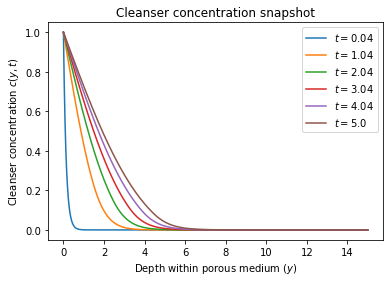

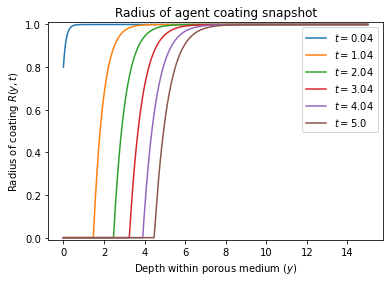

In [2]:
# TIME PARAMETERS: 

T = 5 # T is the time of simulation 

# PROBLEM GEOMETRY SPECIFICATION:

# We solve the problem on an interval [0, max_depth]
max_depth = 15

# PARAMETERS OF PROBLEM

alpha = 0.1 # alpha is the ratio of circular medium to pore lengthscale
beta = 0.1 # beta is the ratio of agent layer radius to radius of solid clogging the medium
gamma = 1 # this is molar volume of agent * agent concentration

# BOUNDARY CONDITION AT BOTTOM OF MEDIUM 

bc_maxdepth = 'Dirichlet' # Choose between Dirichlet or Neumann conditions

finalagentonpores_1d(T, max_depth, alpha, beta, gamma, bc_maxdepth)

## 3.3 Tracking the cleansing interface

We define $h(t)$ to be the cleansing interface, i.e. the depth to which we have managed to clean the interface. In theory, this is imagined to be:

\begin{equation}
h(t) = \sup \{ y \geq 0 :  R(y,t) = 0  \}.
\end{equation}

# 4 Asymptotics for the non-dimensionalised model

We consider the special case when $\beta \ll 1$. This corresponds to the special case when the agent coating is very thin compared to the lengthscale of the pore. For contrast, $\alpha \ll 1$ means that the radius of the solid medium is very small compared to the pore lengthscale, whereas $\beta / \alpha \ll 1$ means that the medium is mostly clogged by the solid as opposed to the agent. 

In that case, we have that $\mathcal{V}(R)$ and $\mathcal{F}(R) =: \nu$ are independent of $R$, since the contribution of the $\beta R$ term is negligible. Also, the diffusivity is constant (to leading order, only the circular matter is clogging the pore), so $\mathcal{D} = 1$. The simplified model now reads (when $R > 0$):

\begin{equation}
c_t = c_{yy} - \nu(1 + \gamma c) c, \\
\beta R_t = - \gamma c,
\end{equation}

where we have defined a new dimensionless parameter $\Gamma = \gamma / \alpha$.
We expand the dependent variables in powers of $\beta$:

\begin{equation}
R = R^{(0)} + \beta R^{(1)} + \beta^2 R^{(2)} + ..., \\
c = c^{(0)} + \beta c^{(1)} + \beta^2 c^{(2)} + ...
\end{equation}

We consider two particular regimes:

## 4.1 $\gamma \sim O(1)$
Assume for now that $\gamma \sim O(1)$, so there is sufficient agent concentration to move the interface considerably. 

Then, we have that at leading order for the radius equation:

\begin{equation}
\beta \left( R^{(0)} + \beta R^{(1)} + \beta^2 R^{(2)} + ... \right)_t = - \gamma \left( c^{(0)} + \beta c^{(1)} + \beta^2 c^{(2)} + ... \right)
\end{equation}

This would imply that to leading order, we have $c^{(0)} = 0$, which contradicts the fact that $c^{(0)}(0,t) = 1$. Therefore, the action takes place very early on, and we must analyse the early time behaviour. In particular, we introduce $t = \beta \tau$ as our new time variable. This requires that we also rescale $y = \sqrt{\beta}Y$. Therefore: 

\begin{equation}
c_{\tau} = c_{YY} - \beta \nu(1 + \gamma c) c.
\end{equation}

So to leading order in $\beta$, we have a heat-like equation, i.e.: 

\begin{equation}
c_{\tau} = c_{YY}, \\
R_{\tau} = - \gamma c.
\end{equation}

This has the solution:

\begin{equation}
c = \text{erfc} \left( \dfrac{Y}{2 \sqrt{\tau}} \right), \\
R = 1 + \gamma \left( Y \sqrt{\dfrac{\tau}{\pi}} e^{-Y^2/4 \tau} - \left( \tau + \dfrac{1}{2} Y^2 \right)  \text{erfc} \left( \dfrac{Y}{2 \sqrt{\tau}} \right)  \right).
\end{equation}

Rewriting this into the original variables, we get the following result:

\begin{equation}
c = \text{erfc} \left( \dfrac{y}{2 \sqrt{t}} \right), \\
R = 1 + \dfrac{\gamma}{\beta} \left( y \sqrt{\dfrac{t}{\pi}} e^{-y^2/4 t} - \left( t + \dfrac{1}{2} y^2 \right)  \text{erfc} \left( \dfrac{y}{2 \sqrt{t}} \right)  \right).
\end{equation}

## 4.2 $\gamma \sim O(\beta)$

To leading order, the equation for the cleanser concentration when $R>0$ reads:

\begin{equation}
c_t = c_{yy} - \nu c. 
\end{equation}

The  full model is:

\begin{equation}
c_{t} = c_{yy} - \nu c, \\
R_{t} = - \left[ \dfrac{\gamma}{\beta}  \right] c.
\end{equation}

when $R>0$, and:

\begin{equation}
c_{t} = c_{yy},
\end{equation}

when $R = 0$. 

To solve this, we split the problem into two regions. Let $s(\tau)$ be the position of the cleansing front, so that:

\begin{equation}
s(t) =  \inf \{t \geq 0 : R(y, t) > 0 \},
\end{equation}

and by the initial condition $s(0) = 0$ (corresponding to not having cleaned anything). 

First, in the region where $0 < y < s(t)$, we have to solve:

\begin{equation}
c_{t} = c_{yy},
\end{equation}

with conditions $c(s(t), t)$ continuous, $c(y, 0) = 0$ and $c(0, t) = 1$.

Next, in the region where $y > s(t)$, we need to solve the following:

\begin{equation}
c_{t} = c_{yy} - \nu c,
\end{equation}

with conditions $c(s(t), t)$ continuous, $c(y, 0) = 0$ and $c(\infty, t) = 0$.

For early time behaviour, when $\epsilon \ll 1$ and $t = \epsilon \tau$.
